### PREPARING DATASET

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('jamb_exam_results.csv')

In [4]:
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

Preparation:

- Remove the student_id column.
- Fill missing values with zeros.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [8]:
del df['student_id']

In [10]:
df = df.fillna(0)

In [11]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)


In [21]:
y_train = df_train.jamb_score.values
y_full_train = df_full_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

In [22]:
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']
del df_full_train['jamb_score']

In [16]:
from sklearn.feature_extraction import DictVectorizer

In [17]:
dv = DictVectorizer(sparse=False)

### QUESTION 1

In [23]:
from sklearn.tree import DecisionTreeRegressor

In [24]:
dicts_train = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dicts_train)

In [28]:
dicts_val = df_val.to_dict(orient='records')
X_val = dv.transform(dicts_val)

In [25]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [35]:
from sklearn.tree import export_text

In [37]:
feature_names = list(dv.get_feature_names_out())
print(export_text(dtr, feature_names=feature_names))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



### QUESTION 2

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [46]:
from sklearn.metrics import root_mean_squared_error as rmse

In [42]:
y_pred = rfr.predict(X_val)

In [ ]:
rmse(y_val, y_pred)

np.float64(42.13724207871227)

### QUESTION 3

In [47]:
score = []

for n_est in range(10, 201, 10):
    rfr = RandomForestRegressor(n_estimators=n_est, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)
    tmp = round(rmse(y_val, y_pred), 3)
    score.append((n_est, tmp))
    print('%d estimator has rmse of %.3f' %(n_est, tmp))

10 estimator has rmse of 42.137
20 estimator has rmse of 41.461
30 estimator has rmse of 41.106
40 estimator has rmse of 40.917
50 estimator has rmse of 40.852
60 estimator has rmse of 40.784
70 estimator has rmse of 40.677
80 estimator has rmse of 40.539
90 estimator has rmse of 40.504
100 estimator has rmse of 40.517
110 estimator has rmse of 40.593
120 estimator has rmse of 40.625
130 estimator has rmse of 40.651
140 estimator has rmse of 40.595
150 estimator has rmse of 40.597
160 estimator has rmse of 40.604
170 estimator has rmse of 40.628
180 estimator has rmse of 40.641
190 estimator has rmse of 40.631
200 estimator has rmse of 40.601


In [48]:
df_score = pd.DataFrame(score, columns=['n_estimator', 'rmse'])

In [50]:
import matplotlib.pyplot as plt

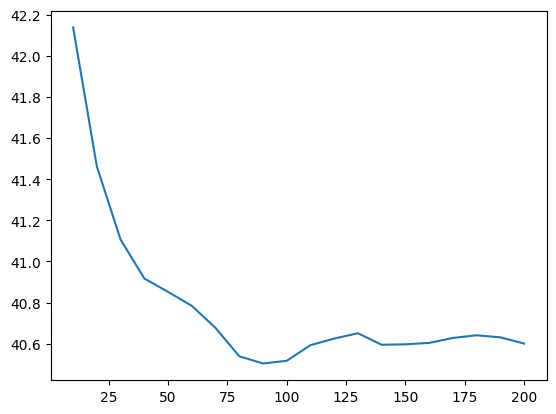

In [59]:
plt.plot(df_score.n_estimator, df_score.rmse)

<p> Around 80, rmse stopped improving

### QUESTION 4

In [60]:
score = []

for m in [10, 15, 20, 25]:
    for n_est in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=n_est, random_state=1, n_jobs=-1, max_depth=m)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        tmp = round(rmse(y_val, y_pred), 3)
        score.append((m, n_est, tmp))
        # print('%d estimator has rmse of %.3f' %(n_est, tmp))

In [61]:
df_score = pd.DataFrame(score, columns=['max_depth', 'n_estimator', 'rmse'])

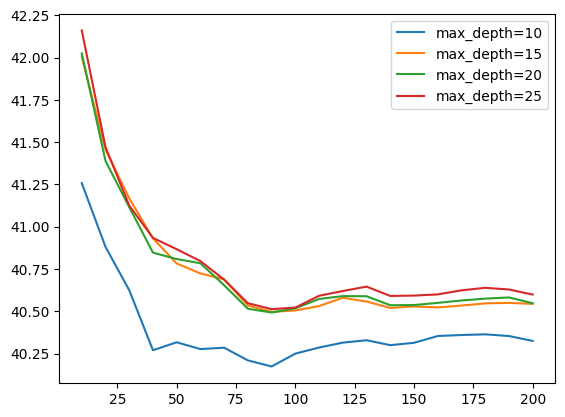

In [64]:
for m in [10, 15, 20, 25]:
    df_subset = df_score[df_score.max_depth == m]
     
    plt.plot(df_subset.n_estimator, df_subset.rmse,
             label='max_depth=%d' % m)
 
plt.legend()

### QUESTION 5

In [65]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1, max_depth=20)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [66]:
rfr.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [71]:
df_feature = pd.DataFrame(zip(feature_names, rfr.feature_importances_), columns=['feature', 'gain'])

In [73]:
df_feature.sort_values(by='gain', ascending=False).head()

,feature,gain
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


### QUESTION 6

In [74]:
import xgboost as xgb

In [79]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [80]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [81]:
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                      evals=watchlist, verbose_eval=5)

[0]	train-rmse:42.69552	val-rmse:44.86028
[5]	train-rmse:34.43646	val-rmse:40.87186
[10]	train-rmse:31.55119	val-rmse:40.83684
[15]	train-rmse:29.08791	val-rmse:41.37832
[20]	train-rmse:27.24424	val-rmse:41.80313
[25]	train-rmse:25.52682	val-rmse:42.16423
[30]	train-rmse:24.12906	val-rmse:42.28557
[35]	train-rmse:22.40407	val-rmse:42.54946
[40]	train-rmse:21.45994	val-rmse:42.77917
[45]	train-rmse:20.39910	val-rmse:42.92252
[50]	train-rmse:19.30407	val-rmse:43.11630
[55]	train-rmse:18.42737	val-rmse:43.38441
[60]	train-rmse:17.42414	val-rmse:43.40830
[65]	train-rmse:16.59974	val-rmse:43.52522
[70]	train-rmse:15.74173	val-rmse:43.77894
[75]	train-rmse:14.87321	val-rmse:43.91229
[80]	train-rmse:14.28350	val-rmse:44.08528
[85]	train-rmse:13.64009	val-rmse:44.22602
[90]	train-rmse:12.90222	val-rmse:44.30365
[95]	train-rmse:12.05464	val-rmse:44.31210
[99]	train-rmse:11.56417	val-rmse:44.43210


In [82]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [83]:
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                      evals=watchlist, verbose_eval=5)

[0]	train-rmse:45.50072	val-rmse:46.99373
[5]	train-rmse:40.15460	val-rmse:43.05644
[10]	train-rmse:37.11353	val-rmse:41.55631
[15]	train-rmse:35.07766	val-rmse:40.70892
[20]	train-rmse:33.57997	val-rmse:40.37859
[25]	train-rmse:32.50134	val-rmse:40.21661
[30]	train-rmse:31.47315	val-rmse:40.20963
[35]	train-rmse:30.68870	val-rmse:40.19360
[40]	train-rmse:29.89807	val-rmse:40.15747
[45]	train-rmse:29.33094	val-rmse:40.21096
[50]	train-rmse:28.58793	val-rmse:40.28533
[55]	train-rmse:27.95277	val-rmse:40.44296
[60]	train-rmse:27.26360	val-rmse:40.55054
[65]	train-rmse:26.56706	val-rmse:40.66625
[70]	train-rmse:26.05959	val-rmse:40.73555
[75]	train-rmse:25.55747	val-rmse:40.76267
[80]	train-rmse:25.13835	val-rmse:40.82813
[85]	train-rmse:24.64140	val-rmse:40.87915
[90]	train-rmse:23.93958	val-rmse:40.89645
[95]	train-rmse:23.39469	val-rmse:40.95651
[99]	train-rmse:23.14487	val-rmse:41.04335


0.1 leads to better rmse